In [1]:
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
import ipywidgets as widgets
from IPython.display import display

In [2]:
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
alpha_min, alpha_max = 0.01, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
n = 75

# Generate samples from normal distributions
a = np.random.normal(mean_a, std_a, n)
b = np.random.normal(mean_b, std_b, n)
w_a = len(a) / (len(a) + len(b))
w_b = 1 - w_a

#Step Parameters
# U+ / U- > C+ / C-
u_plus = 1
u_minus = -1.1
c_plus = 1
c_minus = -c_plus
print( "U+ / U- > C+ / C- is", (u_plus / u_minus) > (c_plus / c_minus) )
domain = (-3, 3)
# 0.1
interval = 0.1

U+ / U- > C+ / C- is True


In [19]:
from utils import opt_threshold, alt_fair_opt_step, opt_step, expected

x_alphas = []
y_mean_A = []
y_mean_B = []
y_thresh_A = []
y_thresh_B = []
y_util = []
y_pof = [] # Price of fairness
y_cat_1 = []
y_cat_4 = []

opt_util_A, opt_util_B = opt_step(a, 1, -1.1, 1, -1)[0], opt_step(b, 1, -1.1, 1, -1)[0]
opt_util_A, opt_util_B  = expected(opt_util_A, 1, -1.1), expected(opt_util_B, 1, -1.1)
opt_util_A, opt_util_B = np.sum(opt_util_A), np.sum(opt_util_B)
y_opt = w_a * opt_util_A + w_b * opt_util_B

for alpha in tqdm(alphas):
    results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha, domain, interval)
    if results[0] is not None and results[1] is not None:
        A, B, thresh_A, thresh_B, max_util = results
        x_alphas.append(alpha)
        
        y_mean_A.append(np.mean(A))
        y_mean_B.append(np.mean(B))
        y_thresh_A.append(thresh_A)
        y_thresh_B.append(thresh_B)
        y_util.append(max_util)
        pof = 1 - (max_util/y_opt)
        y_pof.append(pof)

        delta_A = expected(a, u_plus, u_minus)
        condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0) & (a > thresh_A)
        condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0) & (a > thresh_A)
        condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0) & (a > thresh_A)

        y_cat_1.append(len(A[condition1]))
        y_cat_4.append(len(A[condition3]))

print(y_opt)
print(y_util[-1])
print(y_pof)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 26.56it/s]

12.373192541641647
12.409599806061319
[np.float64(0.22905126643300322), np.float64(0.22905126643300322), np.float64(0.21885021282616302), np.float64(0.21301231571473167), np.float64(0.21301231571473167), np.float64(0.19450741896223778), np.float64(0.19450741896223778), np.float64(0.19450741896223778), np.float64(0.17443913037988656), np.float64(0.17443913037988656), np.float64(0.17443913037988656), np.float64(0.14737736042843463), np.float64(0.13351286186802003), np.float64(0.13351286186802003), np.float64(0.1127451695472842), np.float64(0.1127451695472842), np.float64(0.08340317065735892), np.float64(0.07771133761946947), np.float64(0.0666562024981937), np.float64(0.05466679396180696), np.float64(0.03333344636202773), np.float64(0.02083063170294619), np.float64(0.004356656477841003), np.float64(-0.002942430928569495), np.float64(-0.002942430928569495), np.float64(-0.002942430928569495), np.float64(-0.002942430928569495), np.float64(-0.002942430928569495), np.float64(-0.002942430928569

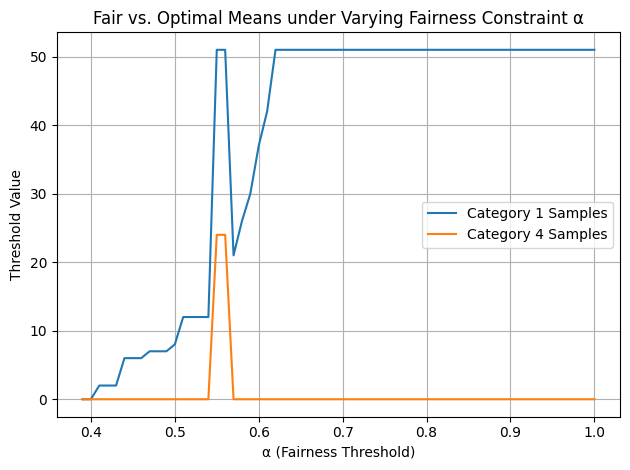

In [22]:
#plt.scatter(x_alphas, y_thresh_A, label="Fair Threshold (A)", color='orange')
#plt.plot(x_alphas, y_thresh_B, label="Fair Threshold (B)", color='purple')
"""plt.plot(x_alphas, y_pof)
plt.axhline(y_opt)
plt.plot(x_alphas, y_util)"""
plt.plot(x_alphas, y_cat_1, label='Category 1 Samples')
plt.plot(x_alphas, y_cat_4, label='Category 4 Samples')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_fairness(show_means=False, show_fair_thresholds=False, show_pof=False, show_utility=False, show_categories=False):
    plt.figure(figsize=(10, 6))

    if show_means:
        plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
        plt.plot(0, mean_b, 'bo', label='Initial μ(B)')
        plt.plot(x_alphas, y_mean_A, label="Fair μ(A)'", color='red')
        plt.plot(x_alphas, y_mean_B, label="Fair μ(B)'", color='blue') 

    if show_fair_thresholds:
        plt.scatter(x_alphas, y_thresh_A, label="Fair Threshold (A)", color='orange')
        plt.scatter(x_alphas, y_thresh_B, label="Fair Threshold (B)", color='purple')
    
    if show_pof:
        plt.scatter(x_alphas, y_pof, label='Price of Fairness', color='blue')

    if show_utility:
        plt.plot(x_alphas, y_util, label='Total Utility', color='green')
    
    if show_categories:
        plt.plot(x_alphas, y_cat_1, label='Category 1 Count', color='red', linestyle='--', marker='o')
        plt.plot(x_alphas, y_cat_4, label='Category 4 Count', color='darkred', linestyle='--', marker='s')

    plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.xlabel("α (Fairness Threshold)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=False, description='Show Means')
fair_thresholds_toggle = widgets.Checkbox(value=False, description='Show Fair Thresholds')
pof_toggle = widgets.Checkbox(value=False, description='Show PoF')
utility_toggle = widgets.Checkbox(value=False, description='Show Utility')
categories_toggle = widgets.Checkbox(value=False, description='Show Categories')

ui = widgets.HBox([means_toggle, fair_thresholds_toggle, pof_toggle, utility_toggle, categories_toggle])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_fair_thresholds': fair_thresholds_toggle,
    'show_pof': pof_toggle,
    'show_utility': utility_toggle,
    'show_categories': categories_toggle,
})

display(ui, out)

Output()

In [6]:
# Check if vectotized algorithm produces the same results as the original algorithm
results = alt_fair_opt_step(pop_A=a, pop_B=b, u_plus=1, u_minus=-1.1, c_plus=1, c_minus=-10, alpha=0.5, range_param=(-3, 3), size=0.05)
from utils import alt_fair_step
l = alt_fair_step(a, b, 1, -1.1, 1, -10, 0.5, (-3, 3), 0.05)

print(np.sum(results[0] + results[1]))
print(np.sum(l[0] + l[1]))


48.32876065466182
48.32876065466182


Threshold A: -1.799999999999999
Threshold A: -1.6999999999999988
Threshold A: -1.5999999999999988
Threshold A: 0.9000000000000035


Text(0.5, 1.0, 'Threshold A with Fixed Threshold B vs Total Utility')

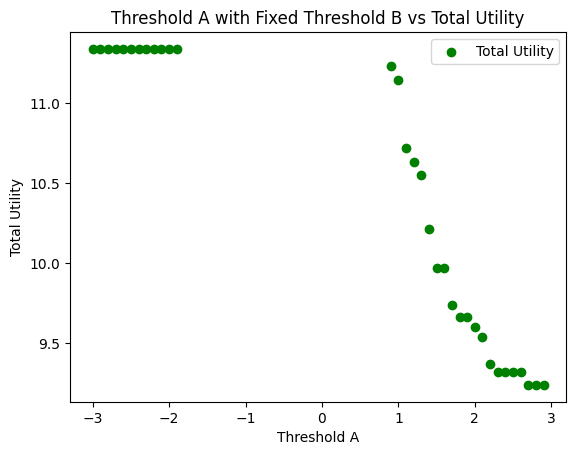

In [11]:
### Experiment where alpha and the threshold of B is fixed while we vary the threshold of A

x_thresh_A = []
thresh_B = y_thresh_B[-1]
y_means_diff = []

from utils import expected
delta_A = expected(a, c_plus, c_minus)
delta_B = expected(b, c_plus, c_minus)

B = np.where(b > thresh_B, b + delta_B, b)
util_B = np.sum(expected(B, u_plus, u_minus))
util_A = []
max_A = None
max_util = None

c1 = []
c3 = []
c4 = []


thresholds = np.arange(domain[0], domain[1], interval)
for threshold in thresholds:
    alpha = 0.55
    A = np.where(a > threshold, a + delta_A, a)
    diff = np.abs(np.mean(A) - np.mean(B))
    if round(diff,2) == alpha:
        print("Threshold A:", threshold)
    y_means_diff.append(diff)
    utility = np.sum(expected(A, u_plus, u_minus))
    if max_util is None or utility > max_util:
        condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0)
        condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0)
        condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0)

        c1_indices = np.where(condition1)[0]
        c3_indices = np.where(condition2)[0]
        c4_indices = np.where(condition3)[0]

        c1 = [c1_indices, a[c1_indices] + expected(a, u_plus, u_minus)[c1_indices], ]
        c3 = [c3_indices, a[c3_indices] + expected(a, u_plus, u_minus)[c3_indices]]
        c4 = [c4_indices, a[c4_indices] + expected(a, u_plus, u_minus)[c4_indices]]

        max_util = utility
        max_A = A
    util_A.append(utility)
    x_thresh_A.append(threshold)

y_means_diff = np.array(y_means_diff)
x_thresh_A = np.array(x_thresh_A)

index = np.where(y_means_diff < alpha)[0]
x_util_thresh_A = x_thresh_A[index]
#x_util_thresh_A = x_thresh_A
w_a = len(a) / ( len(a) + len(b) )
w_b = 1 - w_a
total_util = w_a * np.array(util_A) + w_b * util_B
total_util = total_util[index]

plt.scatter(x_util_thresh_A, total_util, label='Total Utility', color='green')
plt.legend()
plt.xlabel("Threshold A")
plt.ylabel("Total Utility")
plt.title("Threshold A with Fixed Threshold B vs Total Utility")


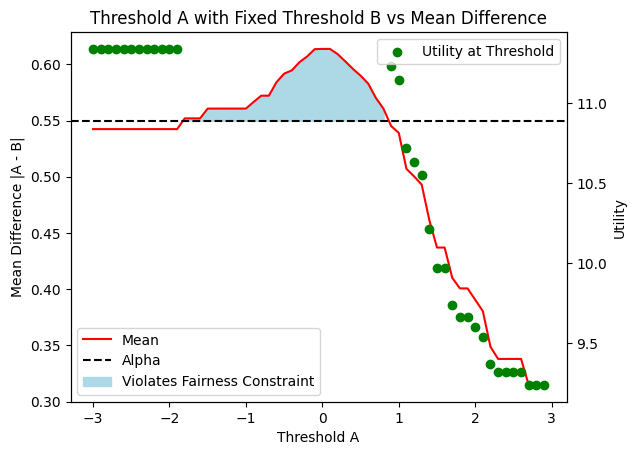

In [8]:
### Experiment where the threshold of B is fixed while we track utility and difference in means

plt.plot(x_thresh_A, y_means_diff, label='Mean', color='red')
plt.axhline(y=alpha, label='Alpha', color='black', linestyle='--')
plt.fill_between(x_thresh_A, y_means_diff, alpha, where=(y_means_diff > alpha), color='lightblue', alpha=1, label='Violates Fairness Constraint')
plt.xlabel("Threshold A")
plt.ylabel("Mean Difference |A - B|")
plt.title("Threshold A with Fixed Threshold B vs Mean Difference")
plt.legend()

ax2 = plt.gca().twinx()
ax2.scatter(x_util_thresh_A, total_util, label='Utility at Threshold', color='green')
ax2.set_ylabel('Utility')
ax2.legend()

Text(0.5, 1.0, 'Distribution of A Before and After Policy')

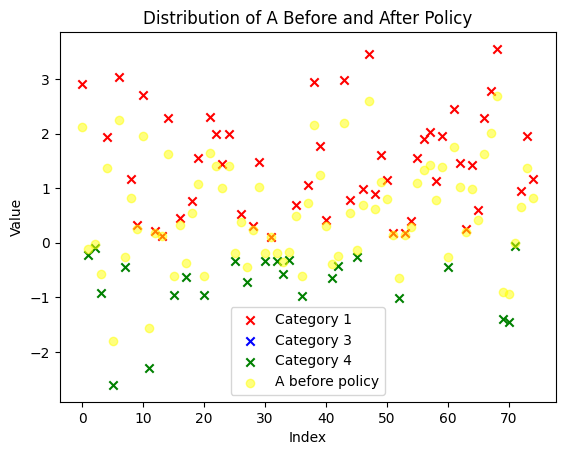

In [9]:
a = np.array(a)
indices = np.arange(len(a))
plt.scatter(c1[0], c1[1], color='red', marker='x', label='Category 1')
plt.scatter(c3[0], c3[1], color='blue', marker='x', label='Category 3')
plt.scatter(c4[0], c4[1], color='green', marker='x', label='Category 4')


plt.scatter(indices, a, color='yellow', alpha=0.5, marker='o', label='A before policy')
#plt.scatter(indices, max_A, color='red', marker='x', label='A after policy')
#plt.axhline(y=-1.5, color='black', linestyle='--')
#plt.axhline(y=0.8, color='black', linestyle='--')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Distribution of A Before and After Policy")

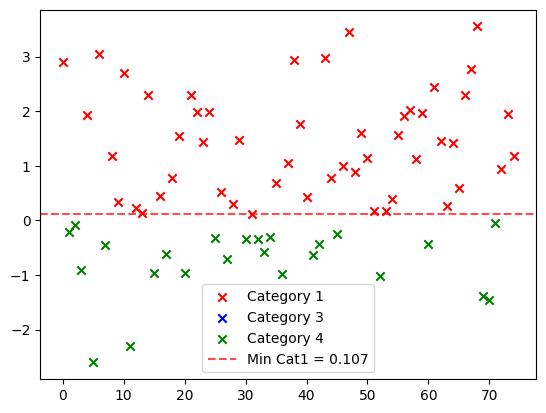

In [12]:
# Define conditions
condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0)
condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0)
condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0)

# Get indices
cat1_ind = np.where(condition1)[0]
cat3_ind = np.where(condition2)[0]
cat4_ind = np.where(condition3)[0]

# Compute categories
cat1 = [cat1_ind, a[cat1_ind] + expected(a, u_plus, u_minus)[cat1_ind]]
cat3 = [cat3_ind, a[cat3_ind] + expected(a, u_plus, u_minus)[cat3_ind]]
cat4 = [cat4_ind, a[cat4_ind] + expected(a, u_plus, u_minus)[cat4_ind]]

# Plot
plt.scatter(cat1[0], cat1[1], color='red', marker='x', label='Category 1')
plt.scatter(cat3[0], cat3[1], color='blue', marker='x', label='Category 3')
plt.scatter(cat4[0], cat4[1], color='green', marker='x', label='Category 4')

# Draw line at smallest cat1 value
if len(cat1[1]) > 0:  # Check if cat1 has any points
    min_cat1_value = np.min(cat1[1])
    plt.axhline(y=min_cat1_value, color='red', linestyle='--', alpha=0.7, 
                label=f'Min Cat1 = {min_cat1_value:.3f}')

plt.legend()
plt.show()